In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
#pip install sqlalchemy pandas (creates database)
from sqlalchemy import create_engine
import sqlite3
import seaborn as sns
from collections import Counter
#networks library for markov model
import networkx as nx

# lets try to run a markov model on the supply chain data to identify change of state trends

In [2]:
#connect to database
df = pd.read_csv('supply_chain_cleaned.csv')


States: 
- PQ sent
- PO sent
- Scheduled
- Delivered
- Recorded


In [3]:
#building the Markov model
states = ['PQ sent', 'PO sent', 'Scheduled', 'Delivered', 'Recorded']
state_date_columns = ['PQ First Sent to Client Date', 'PO Sent to Vendor Date', 'Scheduled Delivery Date', 'Delivered to Client Date', 'Delivery Recorded Date']

#Counts the transitions per state ina  tuple format (from_state, to_state)
transition_counts = Counter()

#loop over each row in the DF, we dont need the index
for _, row in df.iterrows():
    state_dates = []
    # col gives the date for that state is it exists
    #zip pairs the state labels and the columns 
    for state, col in zip(states, state_date_columns):
        raw_value = row[col]

        #so we get the raw value which can be "pre PQ process" or anything thing else and validate that it is a date, and if not then put NaT
        #error = corece means that if the value cannot be converted to a date, it will return NaT (Not a Time)
        date_value = pd.to_datetime(raw_value, errors='coerce')

        # if the date_value is not null, we append the state and date_value to the state_dates list
        if pd.notnull(date_value):
            state_dates.append((state, date_value))

    
    # Sort the dates of the states (index 1) in the order from earliest to latest
    state_dates_sorted = sorted(state_dates, key=lambda x: x[1])
    
    # Extract just the states in order, so drop the dates and keep the states, then we can find the order of the states so it does PQ sent -> PO sent -> Scheduled -> Delivered -> Recorded
    state_sequence = [s for s, _ in state_dates_sorted]
    
    # Count transitions, so it has in the form: Pairs are:
        # PQ → PO
        # PO → Scheduled
        # Scheduled → Delivered
    #we are just counting the transitions between states such that if transition_counts is both true we add 1

    for i in range(len(state_sequence) - 1):
        from_state = state_sequence[i]
        to_state = state_sequence[i+1]
        transition_counts[(from_state, to_state)] += 1

for (from_state, to_state), count in transition_counts.items():
    print(f"{from_state} to {to_state}: {count}")



Scheduled to Delivered: 7510
Delivered to Recorded: 10079
PO sent to Scheduled: 4340
PO sent to Delivered: 239
Recorded to Scheduled: 2574
Delivered to PO sent: 1
PO sent to Recorded: 4
Scheduled to PO sent: 1
PQ sent to PO sent: 3835
Recorded to PQ sent: 4
PQ sent to Scheduled: 1430
Delivered to Scheduled: 236
Scheduled to Recorded: 238
Recorded to PO sent: 2
PO sent to PQ sent: 5
Recorded to Delivered: 1
PQ sent to Delivered: 2375
Delivered to PQ sent: 6
PQ sent to Recorded: 3


In [4]:
#visualize the transitions into a transition matrix

#create a dataframe of 0s with the states as both the index and columns
matrix = pd.DataFrame(0, index=states, columns=states)

# Fill the matrix with transition counts
for (from_state, to_state), count in transition_counts.items():
    matrix.loc[from_state, to_state] = count

matrix

,PQ sent,PO sent,Scheduled,Delivered,Recorded
PQ sent,0,3835,1430,2375,3
PO sent,5,0,4340,239,4
Scheduled,0,1,0,7510,238
Delivered,6,1,236,0,10079
Recorded,4,2,2574,1,0


In [5]:
#creating a transition matrix by getting the from_state for each row and dividing by the sum of the counts for that row
prob_matrix = matrix.div(matrix.sum(axis=1), axis=0)
print(prob_matrix)

            PQ sent   PO sent  Scheduled  Delivered  Recorded
PQ sent    0.000000  0.501766   0.187099   0.310742  0.000393
PO sent    0.001090  0.000000   0.945946   0.052092  0.000872
Scheduled  0.000000  0.000129   0.000000   0.969157  0.030714
Delivered  0.000581  0.000097   0.022864   0.000000  0.976458
Recorded   0.001550  0.000775   0.997288   0.000387  0.000000


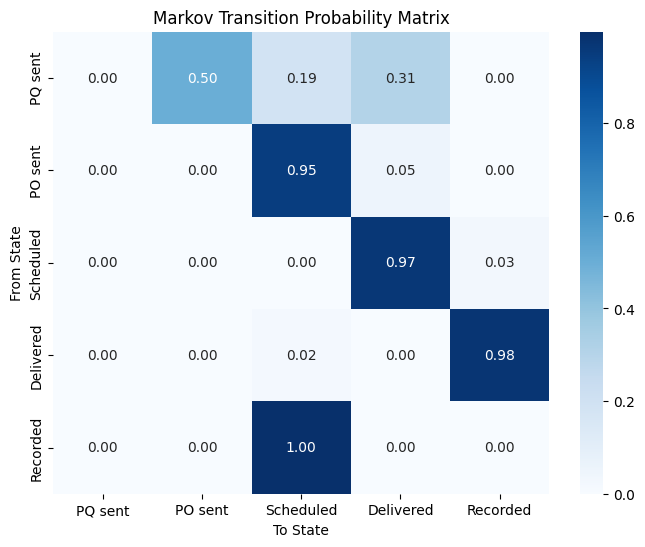

In [6]:
#plot the porbability matrix, we are focusing on the transition probabilities between states int he order PQ sent -> PO sent -> Scheduled -> Delivered -> Recorded
plt.figure(figsize=(8, 6))
sns.heatmap(prob_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Markov Transition Probability Matrix')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

In [7]:
#get the states of the matrix as a list
states_list = list(prob_matrix.columns)

def simulate_markov(start_state, steps):
    current = start_state
    path = [current]
    #itterate for the number of steps
    for _ in range(steps):
        #get the proabilities for the current state as it transitions to any other state
        probs = prob_matrix.loc[current].values
        next_state = np.random.choice(states_list, p=probs)
        path.append(next_state)
        current = next_state
    return path

print(simulate_markov('PQ sent', 10))


['PQ sent', np.str_('Scheduled'), np.str_('Delivered'), np.str_('Recorded'), np.str_('Scheduled'), np.str_('Delivered'), np.str_('Recorded'), np.str_('Scheduled'), np.str_('Delivered'), np.str_('Recorded'), np.str_('Scheduled')]


In [ ]:
# #create a directed graph to visualize the Markov model
G = nx.DiGraph()

#loop over all state pairs
for from_state in prob_matrix.index:
    for to_state in prob_matrix.columns:
        #get the transition probability from each of the from states to the to states
        prob = prob_matrix.loc[from_state, to_state]
        #get rid of transitions that are not significant and fouc on the ones that are >.01
        if prob > 0.01: 
            #add edges to the graph conveying the different states, adds an edge from the from stste to the to state. Weight is highlighted by the probablity rounded to 2 decimal places
            G.add_edge(from_state, to_state, weight=prob, label=f"{prob:.2f}")


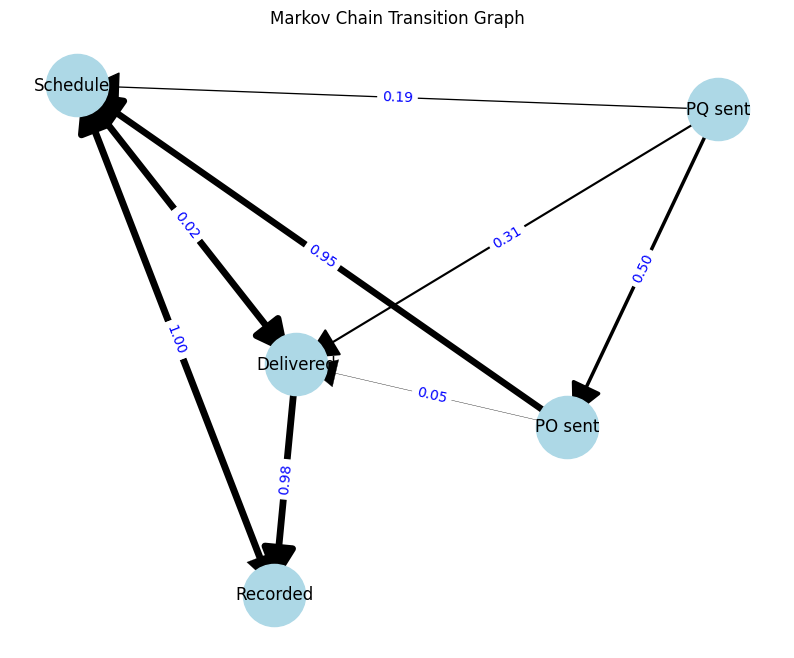

In [23]:
plt.figure(figsize=(10, 8))

# get the node positions using an automatic layout algorithm, nodes repel each other like a springs to avoid overlap
pos = nx.spring_layout(G, seed=42)

# plots each state as a circle ont he graph 
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2000)

# returns a list of edges in the graph
edges = G.edges()
#give each edge a weighting based on the transition probability, this will scale the line thickness, the mult by 5 is to make the lines more visible/thick based on the probability of row/col G[u][v]
weights = [G[u][v]['weight'] * 5 for u,v in edges]  # scale line thickness
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>',arrows=True, arrowsize=50, width=weights)

# Draw labels on the nodes
nx.draw_networkx_labels(G, pos, font_size=12)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='b')

plt.title("Markov Chain Transition Graph")
plt.axis('off')
plt.show()
